# Explore Absolut Data

We obtain the complete Absolut data. In this notebook, we explore it.

Of interest, based on the Readme:
- `RawBindingsMurine/`: the main database
    - `UniqueCDR3s.txt`: murine CDRH3 sequences that have been used (reference to paper), **not found**.
    - `XXXX_X.zip`: optimal binding of each 11-mer from each CDRH3 to this antigen
- `RawBindingsPerClassMurine/`: filtered w/ affinity
    - `XXXX_XAnalyses/`: filtered sequences to antigen XXXX_X
        - CDRH3-based top sequences
        - **11-mer based top sequences**: th defined using CDRH3, but contains multiple 11-mers from the same CDRH3 if they satisfy the threshold

Then there are processed datasets (had been used in Robert 2021 biorxiv):
- `Datasets1/`: binary classification per antigen
- `Datasets2/`: as above, but harder.
- `Datasets3/`: multi-class classification for subsets of N antigens
    - `nonRedundant_11mer-based/`: 142 non-redundant antigens. Includes:
        - binding profile: each bottom 1% CDRH3 to each antigen
- `Datasets4_Paratope_Epitope/`: includes encodings, such as degree-explicit/free, motiv, aggregate, chemical,
- `DatasetsAdditional/`: includes variations of others.

Q&A:
1. Why 11-mer?
2. What are the source unique CDR3s?
    - CDRH3 sequences of murine naive B cells.
3. What have been we using until now in terms of data?
    - top **70k best binders** for 10 different antigens.
        - best binders is probably meant by energy
        - not clear how much this covers in terms of %, since the distribution might be different across antigens.
    - the associated FeaturesFile includes paratope/epitope info.
    - Mat also send the 7M dataset, that included many more Slides, and `Best` col indicates which Slide yielded best binding from all Slides from a CDRH3 source.
4. What has been done on sequence encoding: degree-explicit/free; motif/aggregate/chemical encodings; gapped-motifs encodings;

In [2]:
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Building multiclass datasets for many antigens

We leverage `Datasets3/` for building multiclass datasets. From Readme:
- `Treated142.txt` => Binding profile of each bottom 1% CDRH3 to each antigen (column) => 142 columns
- `ListAntigens142.txt` => name/meaning of columns of Treated142.txt in this order
- Task2Annotated_142_nonredundant.zip => annotation of each sequence with the status "non-binder (top 99%)" or which antigens it bind if binder (bottom 1%). This was used to generate Treated142.txt, provided for information.

In [56]:
with open("../data/Absolut/data/Datasets3/nonRedundant_11mer-based/ListAntigens142.txt", "r") as f:
    antigens = f.read().splitlines()
print(f"{antigens[:5]=}")

df = pd.read_csv(Path('../data/Absolut/data/Datasets3/nonRedundant_11mer-based/Treated142.txt'), sep='\t', header=None)
df.columns = ["Slide", "num_binding_ags", "binding_profile"]
df.head()

antigens[:5]=['1ADQ_A', '1FBI_X', '1FNS_A', '1FSK_A', '1H0D_C']


,Slide,num_binding_ags,binding_profile
0,AAAFITTVVPF,1,0000000000000000000000000000000000000010000000...
1,AAAGWLLLFDY,2,0000000000000100000000000000000000000000000000...
2,AAAIYWYFDVW,3,0000000000000010000010000000000000000010000000...
3,AAALLRSWFAY,1,0000000000000000000000000000000000000010000000...
4,AAALLRYPFAY,3,0001000000000000000000000000000000000010000000...


How many antigens binds a Slide on average?

df["num_binding_ags"].describe()=count    1.286631e+06
mean     5.902470e+00
std      9.812375e+00
min      1.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      6.000000e+00
max      1.110000e+02
Name: num_binding_ags, dtype: float64
df["num_binding_ags"].value_counts(normalize=True).head(10)=1     0.432816
2     0.142812
3     0.077307
4     0.051771
5     0.037965
6     0.029740
7     0.023767
8     0.019575
9     0.016290
10    0.014086
Name: num_binding_ags, dtype: float64


<AxesSubplot:>

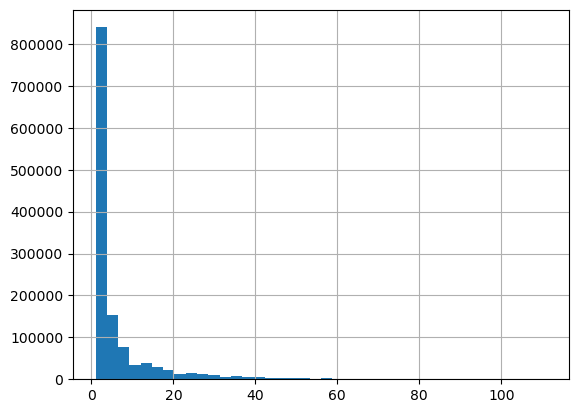

In [57]:
print(f'{df["num_binding_ags"].describe()=}')
print(f'{df["num_binding_ags"].value_counts(normalize=True).head(10)=}')
df["num_binding_ags"].hist(bins=40)

### Processing the dataset

In [59]:
df_wide = pd.DataFrame.from_records(
    data=df["binding_profile"].apply(lambda x: {antigens[i]: int(x[i]) for i in range(len(antigens))}).to_list(),
)
assert all(df_wide.sum(axis=1) == df["num_binding_ags"])

df_wide.index = df["Slide"]
df_wide.head()

,1ADQ_A,1FBI_X,1FNS_A,1FSK_A,1H0D_C,1JPS_T,1KB5_AB,1NCB_N,1NSN_S,1OAZ_A,...,5JZ7_A,5KN5_C,5KTE_A,5L0Q_A,5LQB_A,5MES_A,5T5F_A,5TH9_A,5TLJ_X,5TZ2_C
Slide,,,,,,,,,,,,,,,,,,,,,
AAAFITTVVPF,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAAGWLLLFDY,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAAIYWYFDVW,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAALLRSWFAY,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAALLRYPFAY,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [80]:
ag_c, ag_o = antigens[:20], antigens[80:]

In [81]:
mask_c = (df_wide[ag_c].sum(axis=1) >= 1) & (df_wide[ag_o].sum(axis=1) == 0)
mask_o = (df_wide[ag_c].sum(axis=1) == 0) & (df_wide[ag_o].sum(axis=1) >= 1)

print(f'{mask_c.sum()=} | {mask_o.sum()=}')

mask_c.sum()=150159 | mask_o.sum()=460635


In [82]:
mask_unimodal = df_wide.sum(axis=1) == 1
print(f'{mask_unimodal.sum()=}')
print(f'{(mask_unimodal & mask_c).sum()=} | {(mask_unimodal & mask_o).sum()=}')

mask_unimodal.sum()=556875
(mask_unimodal & mask_c).sum()=94273 | (mask_unimodal & mask_o).sum()=209231
